In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_routines import SHMF, CSMF, SHMR
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


In [2]:
as_data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")
as_red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

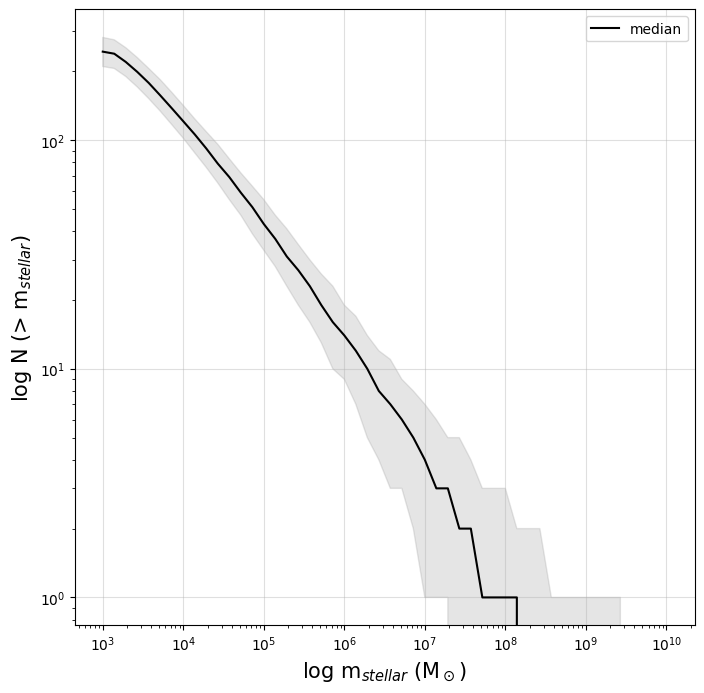

In [3]:
Ms = SHMR(as_data)

surv_massr, surv_CSMF = CSMF(Ms) # accreation mass of the surviving halos!

In [4]:
scatter_pix = 50

scatter_range = np.linspace(0,.4,scatter_pix)

In [5]:
mat = np.zeros(shape=(scatter_pix, 3, 50))

for i,val in enumerate(scatter_range):
    
    surv_massr_i, surv_CSMF_i = CSMF(SHMR(as_data, scatter=val), plot=False) 

    mat[i] = surv_CSMF_i

In [6]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis_r)

colors = mpl.cm.viridis_r(np.linspace(0, 1, scatter_pix))

/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_16931/2898006626.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cmap, label="SHMR scatter (dex)")


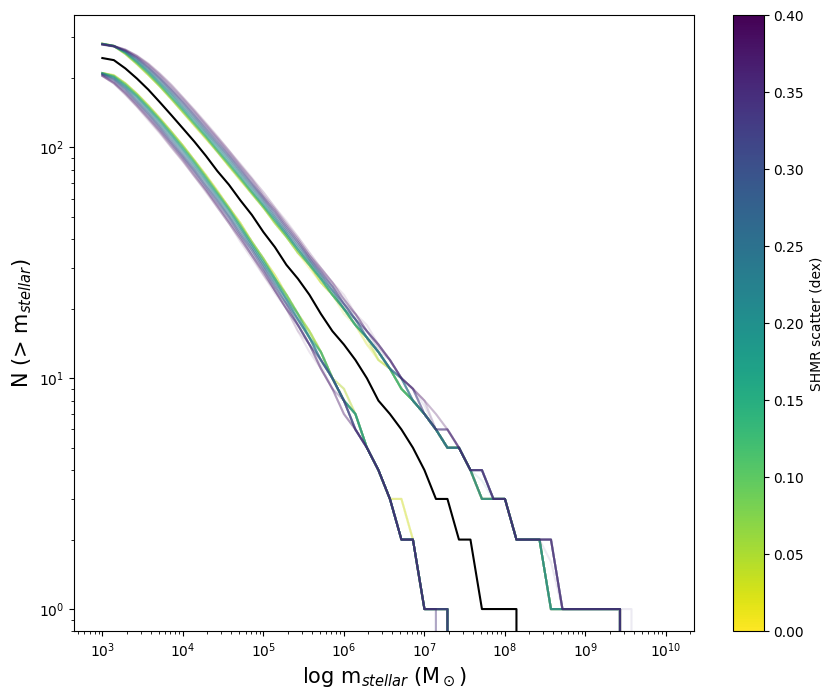

In [7]:
plt.figure(figsize=(10,8))

for i,val in enumerate(mat):
    
    plt.plot(surv_massr, val[0,:], alpha=0.1, color=colors[i])
    plt.plot(surv_massr, val[2,:], alpha=0.1, color=colors[i])

plt.plot(surv_massr, surv_CSMF[1,:], color="black")

plt.yscale("log")
plt.xscale("log")
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

In [8]:
N_diff_4 = mat[:,2,8] - mat[:,0,8]

N_diff_5 = mat[:,2,15] - mat[:,0,15]

N_diff_6 = mat[:,2,22] - mat[:,0,22]

real_diff_4 = surv_CSMF[2, 8] - surv_CSMF[0, 8]

real_diff_5 = surv_CSMF[2, 15] - surv_CSMF[0, 15]

real_diff_6 = surv_CSMF[2, 22] - surv_CSMF[0, 22]

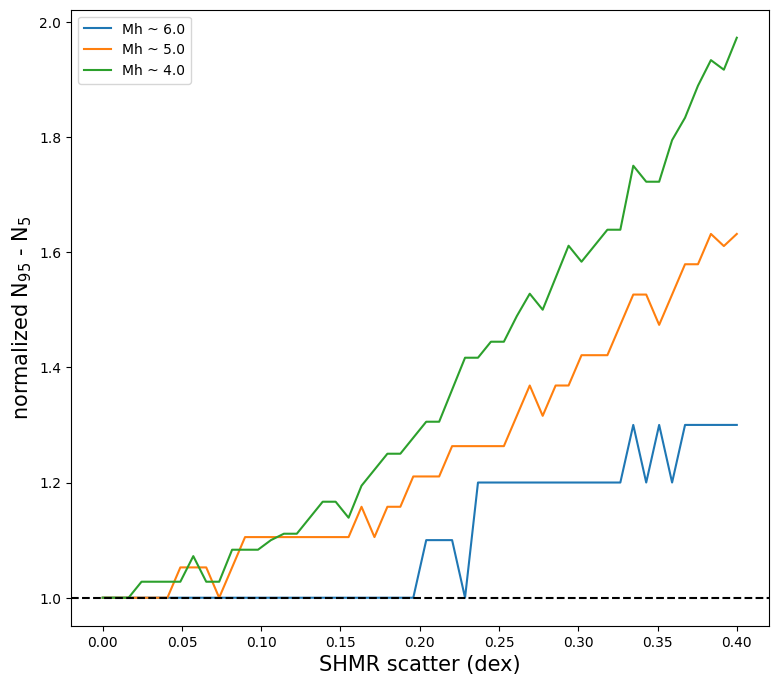

In [9]:
plt.figure(figsize=(9,8))

plt.plot(scatter_range, N_diff_6/real_diff_6, label="Mh ~ "+str(np.round(np.log10(surv_massr[22]))))
plt.plot(scatter_range, N_diff_5/real_diff_5, label="Mh ~ "+str(np.round(np.log10(surv_massr[15]))))
plt.plot(scatter_range, N_diff_4/real_diff_4, label="Mh ~ "+str(np.round(np.log10(surv_massr[8]))))


plt.axhline(1, color="black", ls="--")
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("normalized $\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.legend()
plt.show()
plt.show()

### now sampling 100 values of scatter

In [10]:
N = 1000

mat = np.zeros(shape=(N, scatter_pix, 3, 50))

for j in range(N):

    for i,val in enumerate(scatter_range):
        
        surv_massr_i, surv_CSMF_i = CSMF(SHMR(as_data, scatter=val), plot=False) 

        mat[j, i] = surv_CSMF_i

KeyboardInterrupt: 

In [11]:
def scatter_stat(CSMF, det_CSMF):

    if len(CSMF.shape) == 4:
        print("averaging over the samples!")
        CSMF = np.average(CSMF,axis=0)
    
    Nreal = CSMF.shape[0]
    Mpix = CSMF.shape[2]

    stat = (CSMF[:,2]-CSMF[:,0])/(det_CSMF[2]-det_CSMF[0])

    print("returning a", Nreal, "by", Mpix, "matrix")
    return stat

In [31]:
stat = scatter_stat(mat[0:577,:,:,:], surv_CSMF)

m4 = stat[:,8]
m5 = stat[:,15]
m6 = stat[:,22]

averaging over the samples!
returning a 50 by 50 matrix


/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_16931/103086646.py:10: RuntimeWarning: divide by zero encountered in divide
  stat = (CSMF[:,2]-CSMF[:,0])/(det_CSMF[2]-det_CSMF[0])
/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_16931/103086646.py:10: RuntimeWarning: invalid value encountered in divide
  stat = (CSMF[:,2]-CSMF[:,0])/(det_CSMF[2]-det_CSMF[0])


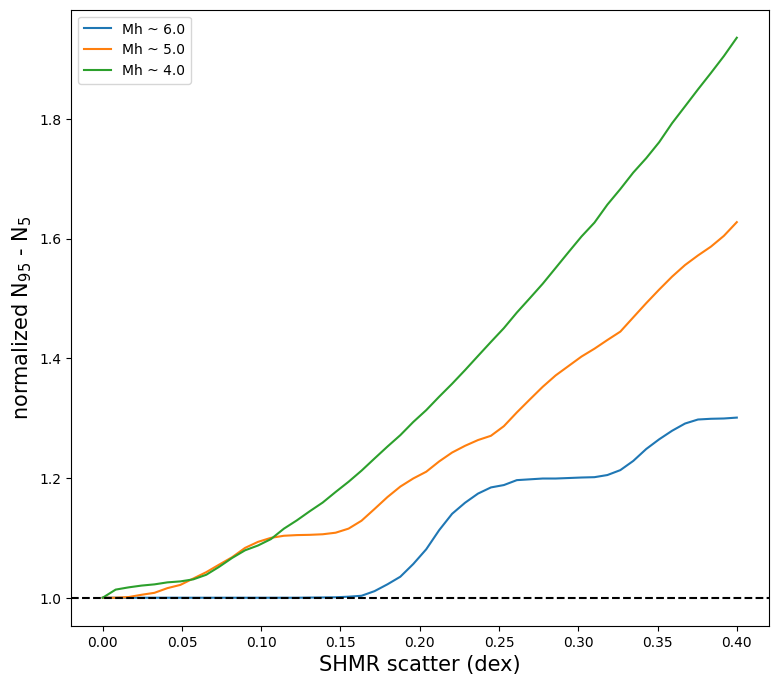

In [34]:
plt.figure(figsize=(9,8))

plt.plot(scatter_range, m6, label="Mh ~ "+str(np.round(np.log10(surv_massr[22]))))
plt.plot(scatter_range, m5, label="Mh ~ "+str(np.round(np.log10(surv_massr[15]))))
plt.plot(scatter_range, m4, label="Mh ~ "+str(np.round(np.log10(surv_massr[8]))))


plt.axhline(1, color="black", ls="--")
plt.xlabel("SHMR scatter (dex)", fontsize=15)
plt.ylabel("normalized $\mathrm{N}_{95}$ - $\mathrm{N}_{5}$", fontsize=15)
plt.legend()
plt.savefig("../figures/CSMF_scatter.pdf")
plt.show()